# Fraud Detection in Electricity and Gas Consumption


We contributed in the Machine Learning Challenge on [Zindi.africa](https://zindi.africa/competitions/fraud-detection-in-electricity-and-gas-consumption-challenge).

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers.

Our aim is to find fraudulent transactions, help save money, avoid reputation damage and prevent money laundering.

In order to prepare the workspace and install a virtual environment and requirements, run in the terminal:

```
pyenv local 3.11.3
python -m venv .venv
source .venv/bin/activate
pip install --upgrade pip
pip install -r requirements.txt
```

## Load required libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import stats

In [2]:
# set options for pandas: remove limits for showing rows and columns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
# define function for inspection of data

def inspect_values(df: pd.DataFrame) -> None:
    '''
    extensive overview of data
    '''
    for column in df.columns:
        print(f"column: {column}", end=' - ')
        if (df[column].dtype not in ['float64', 'int64', 'datetime64[ns]']) or (df[column].nunique() < 15):
            print(f"unique values: {df[column].unique()}", end=' - ')
        else:
            print(f"values: from {min(df[column])} to {max(df[column])}", end=' - ')
        print(f"datatype: {df[column].dtype}" , end=' - ')
        print('number of NaN values:', df[column].isna().sum())

## Load and inspect data

###  Column meanings

Client table
-    Client_id: Unique id for client
-    District: District where the client is
-    Client_catg: Category client belongs to
-    Region: Area where the client is
-    Creation_date: Date client joined
-    Target: fraud:1 , not fraud: 0


Invoice table
-   Client_id: Unique id for the client
-    Invoice_date: Date of the invoice
-    Tarif_type: Type of tax
-    Counter_number:
-    Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
-    Counter_code:
-    Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
-    Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
-    Consommation_level_1: Consumption_level_1
-    Consommation_level_2: Consumption_level_2
-    Consommation_level_3: Consumption_level_3
-    Consommation_level_4: Consumption_level_4
-    Old_index: Old index
-    New_index: New index
-    Months_number: Month number
-    Counter_type: Type of counter



In [5]:
clients = pd.read_csv('data/train/client_train.csv', low_memory=False, parse_dates=True)
invoices = pd.read_csv('data/train/invoice_train.csv', low_memory=False, parse_dates=True)

In [6]:
clients.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [7]:
clients[clients['target'] == 1].shape[0] /clients.shape[0]

0.05584052312665599

Of all the 135493 clients, 5.58 % were flagged as fraudulent. 

In [8]:
invoices.describe()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number
count,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06,4.476749e+06
mean,2.012804e+01,1.230587e+11,1.724884e+02,7.321702e+00,1.003040e+00,4.109795e+02,1.093225e+02,2.030620e+01,5.292588e+01,1.776700e+04,1.834970e+04,4.483095e+01
std,1.347256e+01,1.657267e+12,1.338871e+02,1.571654e+00,3.083466e-01,7.573080e+02,1.220123e+03,1.574239e+02,8.754725e+02,4.036693e+04,4.095321e+04,3.128335e+03
min,8.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.100000e+01,1.211080e+05,5.000000e+00,6.000000e+00,1.000000e+00,7.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.791000e+03,2.056000e+03,4.000000e+00
50%,1.100000e+01,4.945610e+05,2.030000e+02,8.000000e+00,1.000000e+00,2.740000e+02,0.000000e+00,0.000000e+00,0.000000e+00,7.690000e+03,8.192000e+03,4.000000e+00
75%,4.000000e+01,1.115161e+06,2.070000e+02,9.000000e+00,1.000000e+00,6.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,2.166000e+04,2.234300e+04,4.000000e+00
max,4.500000e+01,2.798115e+13,6.000000e+02,4.130000e+02,5.000000e+01,9.999100e+05,9.990730e+05,6.449200e+04,5.479460e+05,2.800280e+06,2.870972e+06,6.366240e+05


In [9]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [10]:
invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [11]:
clients.shape

(135493, 6)

In [12]:
invoices.shape

(4476749, 16)

In [13]:
# inspect clients table
inspect_values(clients)

column: disrict - unique values: [60 69 62 63] - datatype: int64 - number of NaN values: 0
column: client_id - unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999'] - datatype: object - number of NaN values: 0
column: client_catg - unique values: [11 12 51] - datatype: int64 - number of NaN values: 0
column: region - values: from 101 to 399 - datatype: int64 - number of NaN values: 0
column: creation_date - unique values: ['31/12/1994' '29/05/2002' '13/03/1986' ... '16/08/2004' '30/08/1978'
 '25/05/1978'] - datatype: object - number of NaN values: 0
column: target - unique values: [0. 1.] - datatype: float64 - number of NaN values: 0


In [14]:
# inspect invoices table
inspect_values(invoices)

column: client_id - unique values: ['train_Client_0' 'train_Client_1' 'train_Client_10' ...
 'train_Client_99997' 'train_Client_99998' 'train_Client_99999'] - datatype: object - number of NaN values: 0
column: invoice_date - unique values: ['2014-03-24' '2013-03-29' '2015-03-23' ... '1995-11-28' '1982-07-04'
 '1996-09-02'] - datatype: object - number of NaN values: 0
column: tarif_type - values: from 8 to 45 - datatype: int64 - number of NaN values: 0
column: counter_number - values: from 0 to 27981145458733 - datatype: int64 - number of NaN values: 0
column: counter_statue - unique values: ['0' '1' '5' '4' '3' '2' '769' 'A' '618' '269375' '46' '420'] - datatype: object - number of NaN values: 0
column: counter_code - values: from 0 to 600 - datatype: int64 - number of NaN values: 0
column: reading_remarque - unique values: [  8   6   9   7 207 413 203   5] - datatype: int64 - number of NaN values: 0
column: counter_coefficient - values: from 0 to 50 - datatype: int64 - number of NaN v

In [19]:
# missing values?

print(clients.isnull().sum())
print(invoices.isnull().sum())

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64
client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64


In [26]:
# duplicates?

print(f"Number of duplicates: {len(invoices)-len(invoices.drop_duplicates())}")

# remove them
invoices.drop_duplicates(inplace=True)

Number of duplicates: 0


In [27]:
print(f"Number of duplicates: {len(clients)-len(clients.drop_duplicates())}")

Number of duplicates: 0


In [28]:
# categorical data? check unique values in columns

print('client data')
for cols in clients.columns:
    print(f"{cols}: {clients[cols].nunique()}")

print('_____________________')
print('invoice data')
for cols in invoices.columns:
    print(f"{cols}: {invoices[cols].nunique()}")

client data
disrict: 4
client_id: 135493
client_catg: 3
region: 25
creation_date: 8088
target: 2
_____________________
invoice data
client_id: 135493
invoice_date: 8275
tarif_type: 17
counter_number: 201893
counter_statue: 12
counter_code: 42
reading_remarque: 8
counter_coefficient: 16
consommation_level_1: 8295
consommation_level_2: 12576
consommation_level_3: 2253
consommation_level_4: 12075
old_index: 155648
new_index: 157980
months_number: 1370
counter_type: 2


## Exploratory Data Analysis 

<Axes: >

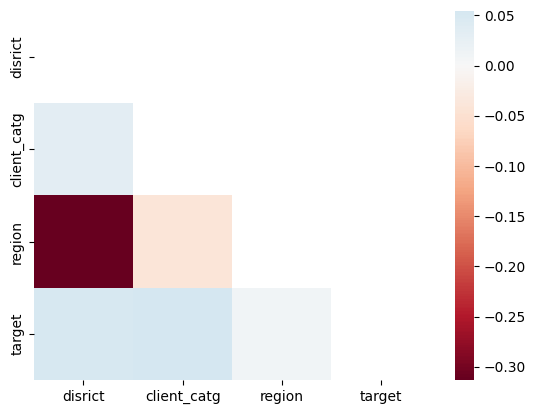

In [15]:
# show correlation plots for clients and invoice data

corr = clients.corr(numeric_only=True)
sns.heatmap(corr, cmap='RdBu', center=0, mask=np.triu(corr))

<Axes: >

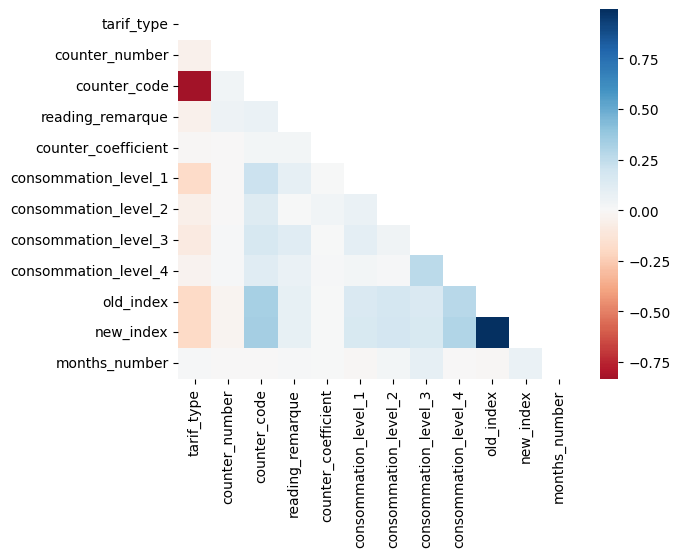

In [16]:
corr = invoices.corr(numeric_only=True)
sns.heatmap(corr, cmap='RdBu', center=0, mask=np.triu(corr))

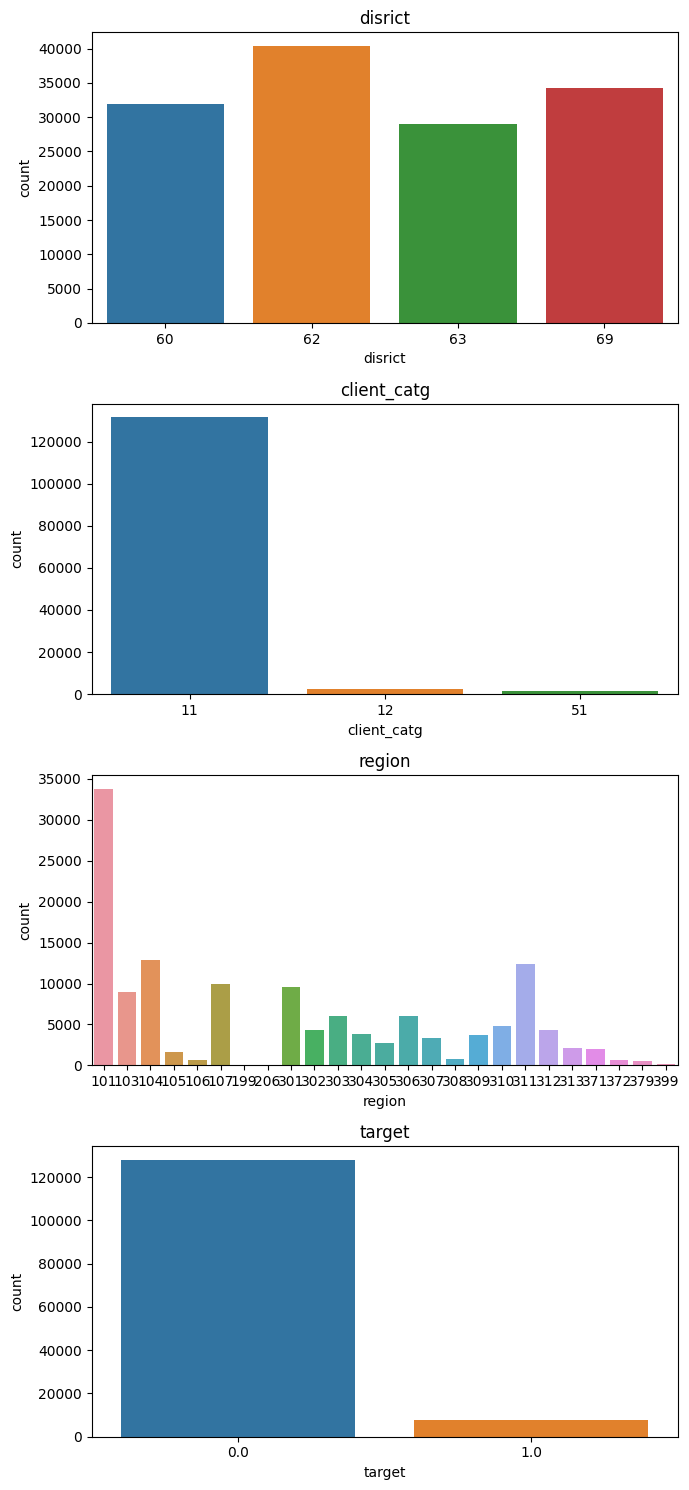

In [30]:
# plot distribution of features
fig, ax = plt.subplots(4)
counter = 0

for col in clients.columns:
    if clients[col].nunique() < 100:
        sns.countplot(data=clients, x=col, ax=ax[counter])
        ax[counter].set_title(col)
        counter += 1

fig.set_figheight(15)
fig.set_figwidth(7)
fig.tight_layout()

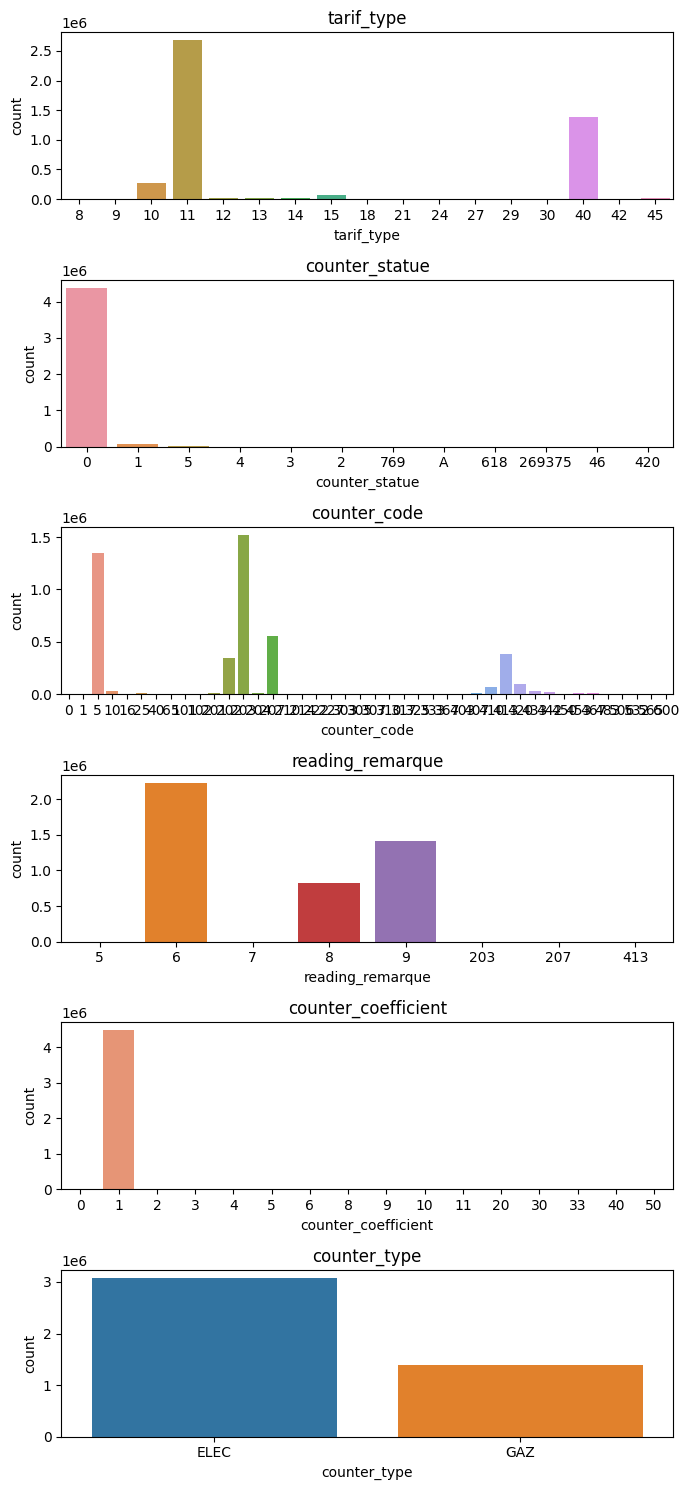

In [31]:
# plot distribution of features
fig, ax = plt.subplots(6)
counter = 0

for col in invoices.columns:
    if invoices[col].nunique() < 100:
        sns.countplot(data=invoices, x=col, ax=ax[counter])
        ax[counter].set_title(col)
        counter += 1

fig.set_figheight(15)
fig.set_figwidth(7)
fig.tight_layout()

## Feature engineering, data cleaning and further EDA


In [32]:
# calculate total consumption
invoices['total_consommation'] = invoices.eval("consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4")

In [33]:
# aggregate total consumption and merge it to client data

invoices_grouped = invoices.groupby('client_id').mean(numeric_only=True)
invoices_grouped.rename(mapper={'total_consommation': 'mean_total_consommation'}, axis=1, inplace=True)
invoices_grouped = invoices_grouped.reset_index()
agg_clients = pd.merge(left=clients, right=invoices_grouped[['client_id', 'mean_total_consommation']], how='left')


In [34]:
# calculate how many counters are associated to each client

count_num = invoices.groupby('client_id').counter_number.nunique().to_frame('number_of_counter_numbers').reset_index()
agg_clients = pd.merge(left=agg_clients, right=count_num, on='client_id')

del count_num

In [35]:
# clean counter_statue column: remove implausible levels 

counter_dict = {'A': 0, '0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 0, '618': 0, '269375': 0, '46': 0, '420': 0}
invoices.counter_statue = invoices.counter_statue.map(lambda x: counter_dict.get(x, x)).astype('int')

invoices.counter_statue.unique()

array([0, 1, 5, 4, 3, 2])

In [36]:
# aggregate counter_statues: merge most common value per client (mode) to client data

df = pd.merge(left=clients, right=invoices, on='client_id', how='left')

counter_statues = df.groupby('client_id').counter_statue.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_counter_statue').reset_index()
agg_clients = pd.merge(left=agg_clients, right=counter_statues, on='client_id')

del counter_statues

In [37]:
# how does reading_remarque look like?
df.groupby(['reading_remarque', 'target']).size()

reading_remarque  target
5                 0.0             1
6                 0.0       2058993
                  1.0        171935
7                 0.0           660
                  1.0             1
8                 0.0        760354
                  1.0         67769
9                 0.0       1303588
                  1.0        113404
203               0.0            15
207               0.0             6
413               0.0            12
dtype: int64

In [38]:
# reassign implausible values, aggregate the most common value per costumer, and merge to client table

remarque_dict = {5: 6, 207: 6, 413: 6, 203: 6}
invoices.reading_remarque = invoices.reading_remarque.map(lambda x: remarque_dict.get(x, x))

reading_mode = invoices.groupby('client_id').reading_remarque.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_reading_remarque').reset_index()
agg_clients = pd.merge(left=agg_clients, right=reading_mode, on='client_id')
del reading_mode

In [39]:
# calculate the range between minimum and maximum monthly consumption per client and merge to client data

min_max = invoices.groupby('client_id').total_consommation.aggregate(['min', 'max'])
rng_total_consommation = min_max.apply(lambda x: x.to_list()[1] - x.to_list()[0], axis=1).to_frame('range_total_consommation').reset_index()

agg_clients = pd.merge(left=agg_clients, right=rng_total_consommation, on='client_id')
del min_max

In [40]:
# convert date column to datetime type

invoices['invoice_date'] = pd.to_datetime(invoices['invoice_date'])

invoices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4476738 entries, 0 to 4476748
Data columns (total 17 columns):
 #   Column                Dtype         
---  ------                -----         
 0   client_id             object        
 1   invoice_date          datetime64[ns]
 2   tarif_type            int64         
 3   counter_number        int64         
 4   counter_statue        int64         
 5   counter_code          int64         
 6   reading_remarque      int64         
 7   counter_coefficient   int64         
 8   consommation_level_1  int64         
 9   consommation_level_2  int64         
 10  consommation_level_3  int64         
 11  consommation_level_4  int64         
 12  old_index             int64         
 13  new_index             int64         
 14  months_number         int64         
 15  counter_type          object        
 16  total_consommation    int64         
dtypes: datetime64[ns](1), int64(14), object(2)
memory usage: 614.8+ MB


In [41]:
# calculate how long has customer been a customer? range in weeks between first and last date per client_id

minmax_date = invoices.groupby('client_id').invoice_date.aggregate(['min','max']).reset_index()

minmax_date['date_interval'] =((minmax_date['max'] - minmax_date['min']) / np.timedelta64(1, 'W')).astype('int')


agg_clients = pd.merge(left=agg_clients, right=minmax_date[['client_id', 'date_interval']], on='client_id')
del minmax_date

In [42]:
# does a client have only electricity, or gas too? merge to client data. 

gaz_type = invoices.groupby('client_id').counter_type.aggregate(['max']).reset_index()

gaz_dict = {'ELEC': 0, 'GAZ':1}
gaz_type['has_gaz'] = gaz_type['max'].map(gaz_dict)

agg_clients = pd.merge(left=agg_clients, right=gaz_type.drop('max', axis=1), on='client_id')
del gaz_type


In [43]:
agg_clients.groupby(['target', 'has_gaz']).has_gaz.size()

target  has_gaz
0.0     0          70320
        1          57607
1.0     0           3119
        1           4447
Name: has_gaz, dtype: int64

In [44]:
# calculate STD of total consumption per customer and merge to client data

std_consommation = invoices.groupby('client_id').total_consommation.std().reset_index()
std_consommation.rename(mapper={'total_consommation': 'std_total_consommation'}, axis=1, inplace=True)
agg_clients = pd.merge(left=agg_clients, right=std_consommation, on='client_id')
del std_consommation

In [45]:
# is the total consumption equal to the difference on customer's meter readings? 

invoices['diff_index'] = invoices['new_index'] - invoices['old_index']
invoices['count_mismatch_per_invoice'] = invoices['total_consommation'] != invoices['diff_index']

count_mismatch = invoices.groupby('client_id')['count_mismatch_per_invoice'].sum().sort_values(ascending=False).reset_index()

agg_clients = pd.merge(left=agg_clients, right=count_mismatch, on='client_id')
del count_mismatch
#invoices.head()

In [46]:
px.histogram(agg_clients[agg_clients.count_mismatch_per_invoice > 0], x='count_mismatch_per_invoice', histfunc='count', color='target')

most customers have little mismatch, but some customers show extreme mismatches in their meter readings compared to their reported total consumption.

<Axes: xlabel='target', ylabel='count_mismatch_per_invoice'>

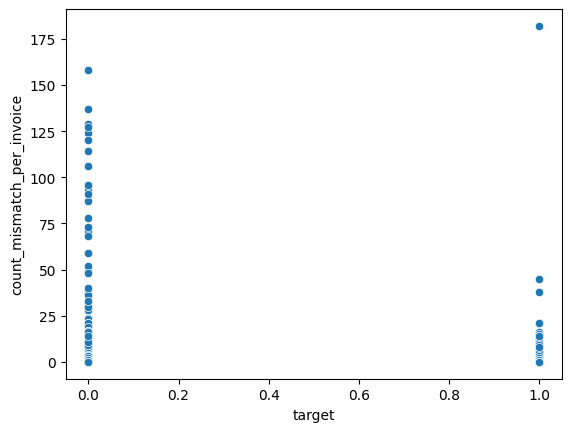

In [47]:
sns.scatterplot(data=agg_clients, x='target', y='count_mismatch_per_invoice')

In [48]:
## before we looked at mismatches for individual invoices. now we focus at total mismatch per client
# and merge the total mismatch to client data

invoices['diff_index'] = invoices['new_index'] - invoices['old_index']
invoices['con_ind_mismatch'] = invoices['total_consommation'] != invoices['diff_index']

count_mismatch = invoices.groupby('client_id')[['diff_index', 'total_consommation']].sum().sort_values('diff_index', ascending=False).reset_index()
count_mismatch['count_mismatch_energy'] = count_mismatch['total_consommation'] - count_mismatch['diff_index']
count_mismatch['count_mismatch_pooled'] = count_mismatch['count_mismatch_energy'] != 0 


agg_clients = pd.merge(left=agg_clients, right=count_mismatch[['client_id', 'count_mismatch_pooled']], on='client_id')
del count_mismatch

In [49]:
px.histogram(agg_clients, x='count_mismatch_pooled', histfunc='count', color='target', barmode='relative', nbins=10, text_auto=True)

In [50]:
# plot count of customers within bins of weeks as a customer and the proportions of fraudulent and legit customers. 

px1 = agg_clients.groupby(['date_interval', 'target']).size().to_frame('count').reset_index()
px1['target'] = px1['target'].map({0: 'legit', 1: 'fraud'})

px.histogram(px1, x='date_interval', y='count', color='target', nbins=20, text_auto=True, labels={'date_interval': 'Weeks as a customer'}, template='plotly_dark', color_discrete_sequence=['#63ac47', '#f8e67c']).update_layout(yaxis_title="Count of customers")

In [51]:
# plot count of customers within each region, with the proportion of legit and fraudulent customers. 

px2 = agg_clients.groupby(['region', 'target']).size().to_frame('count').reset_index()
px2['target'] = px2['target'].map({0: 'legit', 1: 'fraud'})

fig = px.bar(px2, x='region', y='count', color='target', text_auto=True, labels={'date_interval': 'Weeks as a customer', 'region': 'Region'}, template='plotly_dark', color_discrete_sequence=['#63ac47', '#f8e67c']).update_layout(yaxis_title="Count of customers")
fig.update_xaxes(type='category')

In [52]:
# display final aggregated invoice and client data

agg_clients.head()

,disrict,client_id,client_catg,region,creation_date,target,mean_total_consommation,number_of_counter_numbers,mode_counter_statue,mode_reading_remarque,range_total_consommation,date_interval,has_gaz,std_total_consommation,count_mismatch_per_invoice,count_mismatch_pooled
0,60,train_Client_0,11,101,31/12/1994,0.0,362.971429,1,0,6,1348,700,0,341.553930,0,False
1,69,train_Client_1,11,107,29/05/2002,0.0,557.540541,1,0,6,1017,701,0,197.935960,0,False
2,62,train_Client_10,11,301,13/03/1986,0.0,836.500000,1,0,6,2894,703,0,646.808386,0,False
3,69,train_Client_100,11,105,11/07/1996,0.0,1.200000,1,0,6,15,380,0,3.607011,0,False
4,62,train_Client_1000,11,303,14/10/2014,0.0,922.642857,1,0,9,2258,226,0,633.485669,0,False


## Baseline model

A customer with exceptional fluctuations in monthly consumption is likely to be a fraud. 
If the clients standard deviation (STD) is higher than the mean STD of all clients, they will be flagged as fraud. 

In [53]:
## Baseline model

# A customer with exceptional fluctuations in monthly (or yearly??) consumption is likely to be a fraud. 
# If the clients STD is higher than the mean STD of all clients, they will be flagged as fraud. 

baseline = invoices.copy()

baseline.eval('total_consommation = consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4', inplace=True)
baseline.head()

base_grouped = baseline.groupby('client_id').total_consommation.std().reset_index()
base_grouped.head()

mean_std = base_grouped.total_consommation.mean()
mean_std

base_grouped['target_baseline'] = base_grouped.total_consommation > mean_std
base_grouped.head()

,client_id,total_consommation,target_baseline
0,train_Client_0,341.553930,False
1,train_Client_1,197.935960,False
2,train_Client_10,646.808386,True
3,train_Client_100,3.607011,False
4,train_Client_1000,633.485669,True


574.2914287468195
Metric (AUC):  0.5775814701898836


<Axes: >

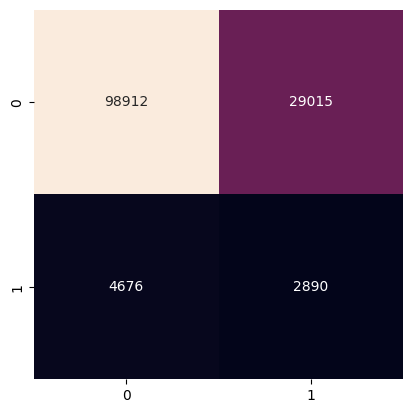

In [55]:
## how good is baseline model?

clients_baseline = pd.merge(left=clients, right=base_grouped.drop(columns='total_consommation', axis=1), on='client_id')

print(mean_std)
print('Metric (AUC): ', roc_auc_score(clients_baseline.target, clients_baseline.target_baseline))
sns.heatmap(confusion_matrix(clients_baseline.target, clients_baseline.target_baseline), square=True, annot=True, fmt='d', cbar=False)

The average STD of all costumers was 574.29. 

The Baseline model was able to correctly identify 2890 clients who committed fraud, and 98912 legit clients. 

The model was not able to catch 4676 fraudsters, and 29015 were incorrectly identified as fraudulent. 

The [Area Under the Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (AUC) was 0.58. 

In [ ]:
# visualize the baseline model

clients_viz = pd.merge(left=clients, right=base_grouped, on='client_id')
px0 = clients_viz.groupby(['total_consommation', 'target']).size().to_frame('count').reset_index()
px0['target'] = px0['target'].map({0: 'legit', 1: 'fraud'})

fig = px.histogram(px0, x='total_consommation', range_x=[0, 2000], y='count', color='target', nbins=4000, text_auto=True, labels={'total_consommation': 'std of total consumption'}, template='plotly_dark', color_discrete_sequence=['#63ac47', '#f8e67c']).update_layout(yaxis_title="Count of customers")
# add vertical line for average STD
fig.add_vline(x=mean_std, annotation_text='average std of all customers')

## Milestone 1  
Fraud Detection Baseline Model \
Value of Product: \
Find fraudulent transactions, safe money, avoid reputation damage and prevent money laundering. \
Prediction: \
Detect anomalies in client's energy consummation behavior \
Evaluation Metric: \
AUC (recommended and given by Zindi) \
Baseline Model: \
A customer with exceptional fluctuations in monthly consummation is likely to be a fraud. \
If the clients' standard deviation of total consummation is higher than the average STD of all clients, they will be flagged as fraud. \
Score:  
AUC = 0.5776

# Modeling

In [59]:
# split dataset into features and target

X = agg_clients.drop(['target', 'client_id', 'creation_date'], axis=1)
y = agg_clients.target

# fill NAs in std column
X.std_total_consommation = X.std_total_consommation.fillna(0)

In [60]:
# create dummies for categorical data

for col in X.columns:
    if X[col].nunique() < 30:
        dummie = pd.get_dummies(X[col], drop_first=True, prefix=col)
        
        X.drop(columns=col, inplace=True)
        X = X.join(dummie, how='left')

## dropped because features missing in test data
X = X.drop(['mode_counter_statue_2', 'region_199'], axis=1)
        
X.head()

,mean_total_consommation,range_total_consommation,date_interval,std_total_consommation,count_mismatch_per_invoice,disrict_62,disrict_63,disrict_69,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,region_107,region_206,region_301,region_302,region_303,region_304,region_305,region_306,region_307,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399,number_of_counter_numbers_2,number_of_counter_numbers_3,number_of_counter_numbers_4,number_of_counter_numbers_5,number_of_counter_numbers_6,number_of_counter_numbers_7,number_of_counter_numbers_8,mode_counter_statue_1,mode_counter_statue_3,mode_counter_statue_4,mode_counter_statue_5,mode_reading_remarque_7,mode_reading_remarque_8,mode_reading_remarque_9,has_gaz_1,count_mismatch_pooled_True
0,362.971429,1348,700,341.553930,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,557.540541,1017,701,197.935960,0,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,836.500000,2894,703,646.808386,0,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1.200000,15,380,3.607011,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,922.642857,2258,226,633.485669,0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


## Linear models

The target in the dataset is highly imbalanced (legit: 127927; fraud: 7566). 
We tried linear models (e.g. logistic regression and SGD classifier) without and with undersampling and oversampling but they yielded unsatisfactory results. 


In [73]:
models = {
    LogisticRegression: {
        "tol": [10**i for i in range(1, -7, -1)],
        "C": [10**i for i in range(-4, 8, 1)],
        "max_iter": [1000, 10000, 100000],
        "l1_ratio": [i/10 for i in range(1, 9, 1)],
        "penalty": ['l1', 'l2', 'elasticnet'],
        "solver": ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
    },
    SGDClassifier: {
        "tol": [10**i for i in range(1, -7, -1)],
        "max_iter": [1000, 10000, 100000]
    }
}
# set scalers, samplers
scalers = [MinMaxScaler, StandardScaler]
samplers = [RandomUnderSampler, SMOTE]
sampling_strategies = [i*0.1 for i in range(1, 9, 3)]
length = len(models.keys()) * len(scalers) * len(samplers) * len(sampling_strategies)
i = 1
results = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


for sampling_strategy in sampling_strategies:
    
    for sampler_ in samplers:
        sampler = sampler_(random_state=0, sampling_strategy=sampling_strategy)
        X_res, y_res = sampler.fit_resample(X_train, y_train)

        for scaler_ in scalers:
            if scaler_:
                scaler = scaler_()
                X_train_scaled = scaler.fit_transform(X_res)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_test_scaled = X_test

            for model, params in models.items():
                print(f"Running model search number {i} out of {length}")
                i += 1
                gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=5, cv=2, verbose=1, n_jobs=-1, error_score=np.NINF)
                gs.fit(X_train_scaled, y_res)
                tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test_scaled)).ravel()
                results[f"{str(gs.best_estimator_).split('(')[0]} - {scaler_} - {sampler_} - {sampling_strategy}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

Running model search number 1 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 2 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 3 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 4 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 5 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 6 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 7 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 8 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 9 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 10 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 11 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 12 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 13 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


8 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with th

Running model search number 14 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 15 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 16 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 17 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 18 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 19 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 20 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 21 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/f

Running model search number 22 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
Running model search number 23 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning:


6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to -inf.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with th

Running model search number 24 out of 24
Fitting 2 folds for each of 5 candidates, totalling 10 fits
LogisticRegression - <class 'sklearn.preprocessing._data.MinMaxScaler'> - <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> - 0.1  -  {'params': "{'tol': 1e-05, 'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 100000, 'l1_ratio': 0.5, 'C': 10000}", 'refit': '0.7957738270083146', 'tn': '38145', 'fp': '212', 'fn': '2204', 'tp': '87'}
SGDClassifier - <class 'sklearn.preprocessing._data.MinMaxScaler'> - <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> - 0.1  -  {'params': "{'tol': 10, 'max_iter': 1000}", 'refit': '0.7385509279139897', 'tn': '38357', 'fp': '0', 'fn': '2291', 'tp': '0'}
LogisticRegression - <class 'sklearn.preprocessing._data.StandardScaler'> - <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> - 0.1  -  {'params': "{'tol': 1e-06, 'solve

## KNN and Decision Tree

We then tried KNN and Decision Tree models and were able to derive better classifications. Still, we found the number of misclassifications unsuitable for business use case. 

In [82]:
models = {
    KNeighborsClassifier: {
        "n_neighbors" : list(range(1, 31)),
        "weights" : ["uniform", "distance"],
        "p" : [1, 2, 3],
        "algorithm": ["ball_tree", "kd_tree", "brute"]
    },
    DecisionTreeClassifier: {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "splitter": ['best', 'random'],
        "max_depth": list(range(2, 12)),
        "min_samples_leaf": list(range(1, 25, 2)),
        "max_leaf_nodes": list((range(4, 25, 3)))
    }
}

samplers = [RandomUnderSampler, SMOTE]
sampling_strategies = [i*0.1 for i in range(1, 9, 3)]
length = len(models.keys()) * len(samplers) * len(sampling_strategies)
i = 1
results = {}
confusions = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


for sampling_strategy in sampling_strategies:
    
    for sampler_ in samplers:
        sampler = sampler_(random_state=0, sampling_strategy=sampling_strategy)
        X_res, y_res = sampler.fit_resample(X_train, y_train)

        for model, params in models.items():
            print(f"Running model search number {i} out of {length}")
            i += 1
            # gs = GridSearchCV(estimator=model(), param_grid=params, scoring=['f1', 'accuracy', 'recall'], refit='f1', cv=5, verbose=1, n_jobs=-1)
            gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=15, cv=2, verbose=1, n_jobs=-1)
            gs.fit(X_res, y_res)
            tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
            results[f"{str(gs.best_estimator_).split('(')[0]} - {sampler_} - {sampling_strategy}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

Running model search number 1 out of 12
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Running model search number 2 out of 12
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Running model search number 3 out of 12
Fitting 2 folds for each of 15 candidates, totalling 30 fits


In [83]:
for key, value in results.items():
    print(key, ' - ', value)

KNeighborsClassifier - <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> - 0.1  -  {'params': "{'weights': 'distance', 'p': 2, 'n_neighbors': 29, 'algorithm': 'kd_tree'}", 'refit': '0.681524345195831', 'roc_auc_test': '0.6776393050803573', 'tn': '38349', 'fp': '8', 'fn': '2290', 'tp': '1'}
DecisionTreeClassifier - <class 'imblearn.under_sampling._prototype_selection._random_under_sampler.RandomUnderSampler'> - 0.1  -  {'params': "{'splitter': 'random', 'min_samples_leaf': 9, 'max_leaf_nodes': 22, 'max_depth': 6, 'criterion': 'log_loss'}", 'refit': '0.7849462022575466', 'roc_auc_test': '0.7906372484183289', 'tn': '38357', 'fp': '0', 'fn': '2291', 'tp': '0'}
KNeighborsClassifier - <class 'imblearn.over_sampling._smote.base.SMOTE'> - 0.1  -  {'params': "{'weights': 'distance', 'p': 1, 'n_neighbors': 14, 'algorithm': 'kd_tree'}", 'refit': '0.8260986226414693', 'roc_auc_test': '0.6291523065935027', 'tn': '38047', 'fp': '310', 'fn': '2226', 'tp':

## Ensemble models

Then we moved on to ensemble models and tried Random Forest Classifiers and Extra Tree Classifiers. This improved the results and yielded more appropriate results.



In [ ]:
models = {
    RandomForestClassifier: {
        "n_estimators": [10, 50, 100],
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": list(range(2, 7)),
        "min_samples_leaf": list(range(1, 25, 2)),
        "max_leaf_nodes": list((range(4, 22, 3)))
    },
    ExtraTreesClassifier: {
        "criterion": ['gini', 'entropy', 'log_loss'],
        "max_depth": list(range(2, 12)),
        "min_samples_split": list(range(2, 25, 2)),
        "min_samples_leaf": list((range(4, 25, 3)))
    }
}


samplers = [RandomUnderSampler, SMOTE]
sampling_strategies = [i*0.1 for i in range(1, 9, 3)]
length = len(models.keys()) * len(samplers) * len(sampling_strategies)
i = 1
results = {}
confusions = {}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


for sampling_strategy in sampling_strategies:
    
    for sampler_ in samplers:
        sampler = sampler_(random_state=0, sampling_strategy=sampling_strategy)
        X_res, y_res = sampler.fit_resample(X_train, y_train)

        for model, params in models.items():
            print(f"Running model search number {i} out of {length}")
            i += 1
            # gs = GridSearchCV(estimator=model(), param_grid=params, scoring=['f1', 'accuracy', 'recall'], refit='f1', cv=5, verbose=1, n_jobs=-1)
            gs = RandomizedSearchCV(estimator=model(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=15, cv=2, verbose=1, n_jobs=-1)
            gs.fit(X_res, y_res)
            tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
            results[f"{str(gs.best_estimator_).split('(')[0]} - {sampler_} - {sampling_strategy}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

## The best model: Balanced Random Forest Classifier

However, the sampling strategy was still not efficient enough, so we decided to move on to use a Balanced Random Forest Classifier. This way, we got the best results within a short period of time. 

Fitting 2 folds for each of 20 candidates, totalling 40 fits


/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/vanessalampe/neuefische/fraud-detection-ML-project/.venv/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow t

BalancedRandomForestClassifier  -  {'params': "{'sampling_strategy': 0.4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 11, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}", 'refit': '0.8067833660068717', 'roc_auc_test': '0.8207018837829767', 'tn': '28973', 'fp': '9384', 'fn': '541', 'tp': '1750'}


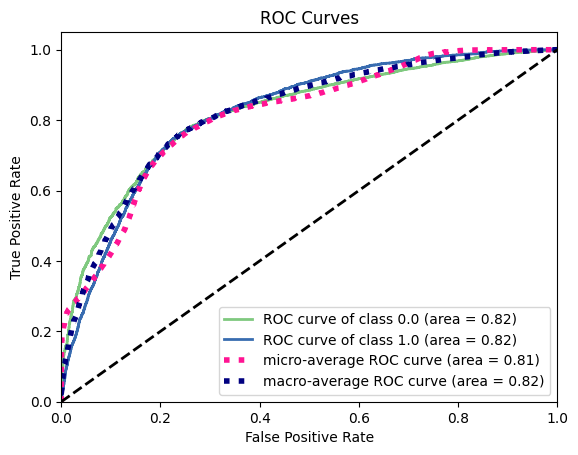

In [61]:
# Balanced Random Forest Classifier
# use a randomized search for hyperparameter tuning

params = {
    # "n_estimators": [],
    "criterion": ['gini', 'entropy'],
    "max_depth": list(range(2, 12)),
    "min_samples_split": list(range(2, 25, 2)),
    "min_samples_leaf": list((range(4, 25, 3))),
    "sampling_strategy": [i*0.1 for i in range(4, 10, 1)],
    "class_weight": ['balanced', 'balanced_subsample']
}


# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# initialise results dict
results = {}
# run randomized search

gs = RandomizedSearchCV(estimator=BalancedRandomForestClassifier(), param_distributions=params, scoring='roc_auc', refit='roc_auc', n_iter=20, cv=2, verbose=1, n_jobs=-1)
gs.fit(X_train, y_train)
tn, fp, fn, tp = confusion_matrix(y_test, gs.predict(X_test)).ravel()
results[f"{str(gs.best_estimator_).split('(')[0]}"] = {'params': f'{gs.best_params_}', 'refit': f'{gs.best_score_}', 'roc_auc_test': f"{roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])}", 'tn': f'{tn}', 'fp': f'{fp}', 'fn': f'{fn}', 'tp': f'{tp}'}


for key, value in results.items():
    print(key, ' - ', value)

# plot ROC curve
import scikitplot as skplt
import matplotlib.pyplot as plt
# 
# 
y_true = y_test # ground truth labels
y_probas = gs.predict_proba(X_test)# predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc(y_true, y_probas, cmap='Accent')

plt.show()

Text(0.5, 1.0, 'Confusion matrix')

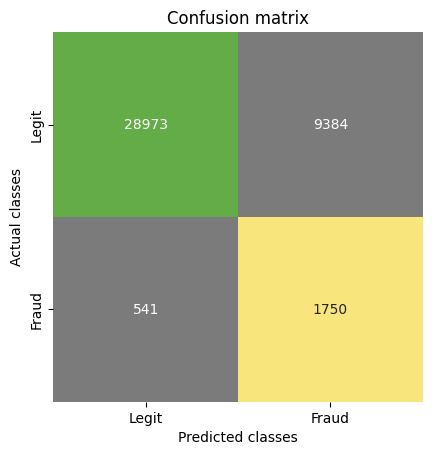

In [64]:
# plot a confusion matrix of model results 

colors = ['#7b7b7b']*1 + ['#f8e67c']*15 + ['#7b7b7b']*40 + ['#63ac47']*4
sns.heatmap(confusion_matrix(y_test, gs.predict(X_test)), square=True, annot=True, fmt='d', cbar=False, cmap=colors)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')
plt.xticks([0.5, 1.5], ['Legit', 'Fraud'])
plt.yticks([0.5, 1.5], ['Legit', 'Fraud'])
plt.title('Confusion matrix')

## Error Analysis

In [63]:
# predict on test data, get rid of dummies, join predicted target and features 
y_pred = gs.predict(X_test)
x_test_numeric_columns = X_test[['mean_total_consommation', 'range_total_consommation', 'date_interval','std_total_consommation', 'count_mismatch_per_invoice']]
x_test_labeled = pd.concat([x_test_numeric_columns, y_true], axis=1)
x_test_labeled = pd.concat([x_test_labeled, pd.Series(y_pred, index=x_test_labeled.index, name='predicted')], axis=1)

In [65]:
def conf_matrix(li: pd.Series):
    target, pred = li.iloc[0], li.iloc[1]
    if target == 1 == pred:
        return 'tp'
    elif target == 0 == pred:
        return 'tn'
    elif target == 1 != pred:
        return 'fn'
    elif target == 0 != pred:
        return 'fp'

x_test_labeled['confusion_matrix'] = x_test_labeled[['target', 'predicted']].apply(conf_matrix, axis=1)

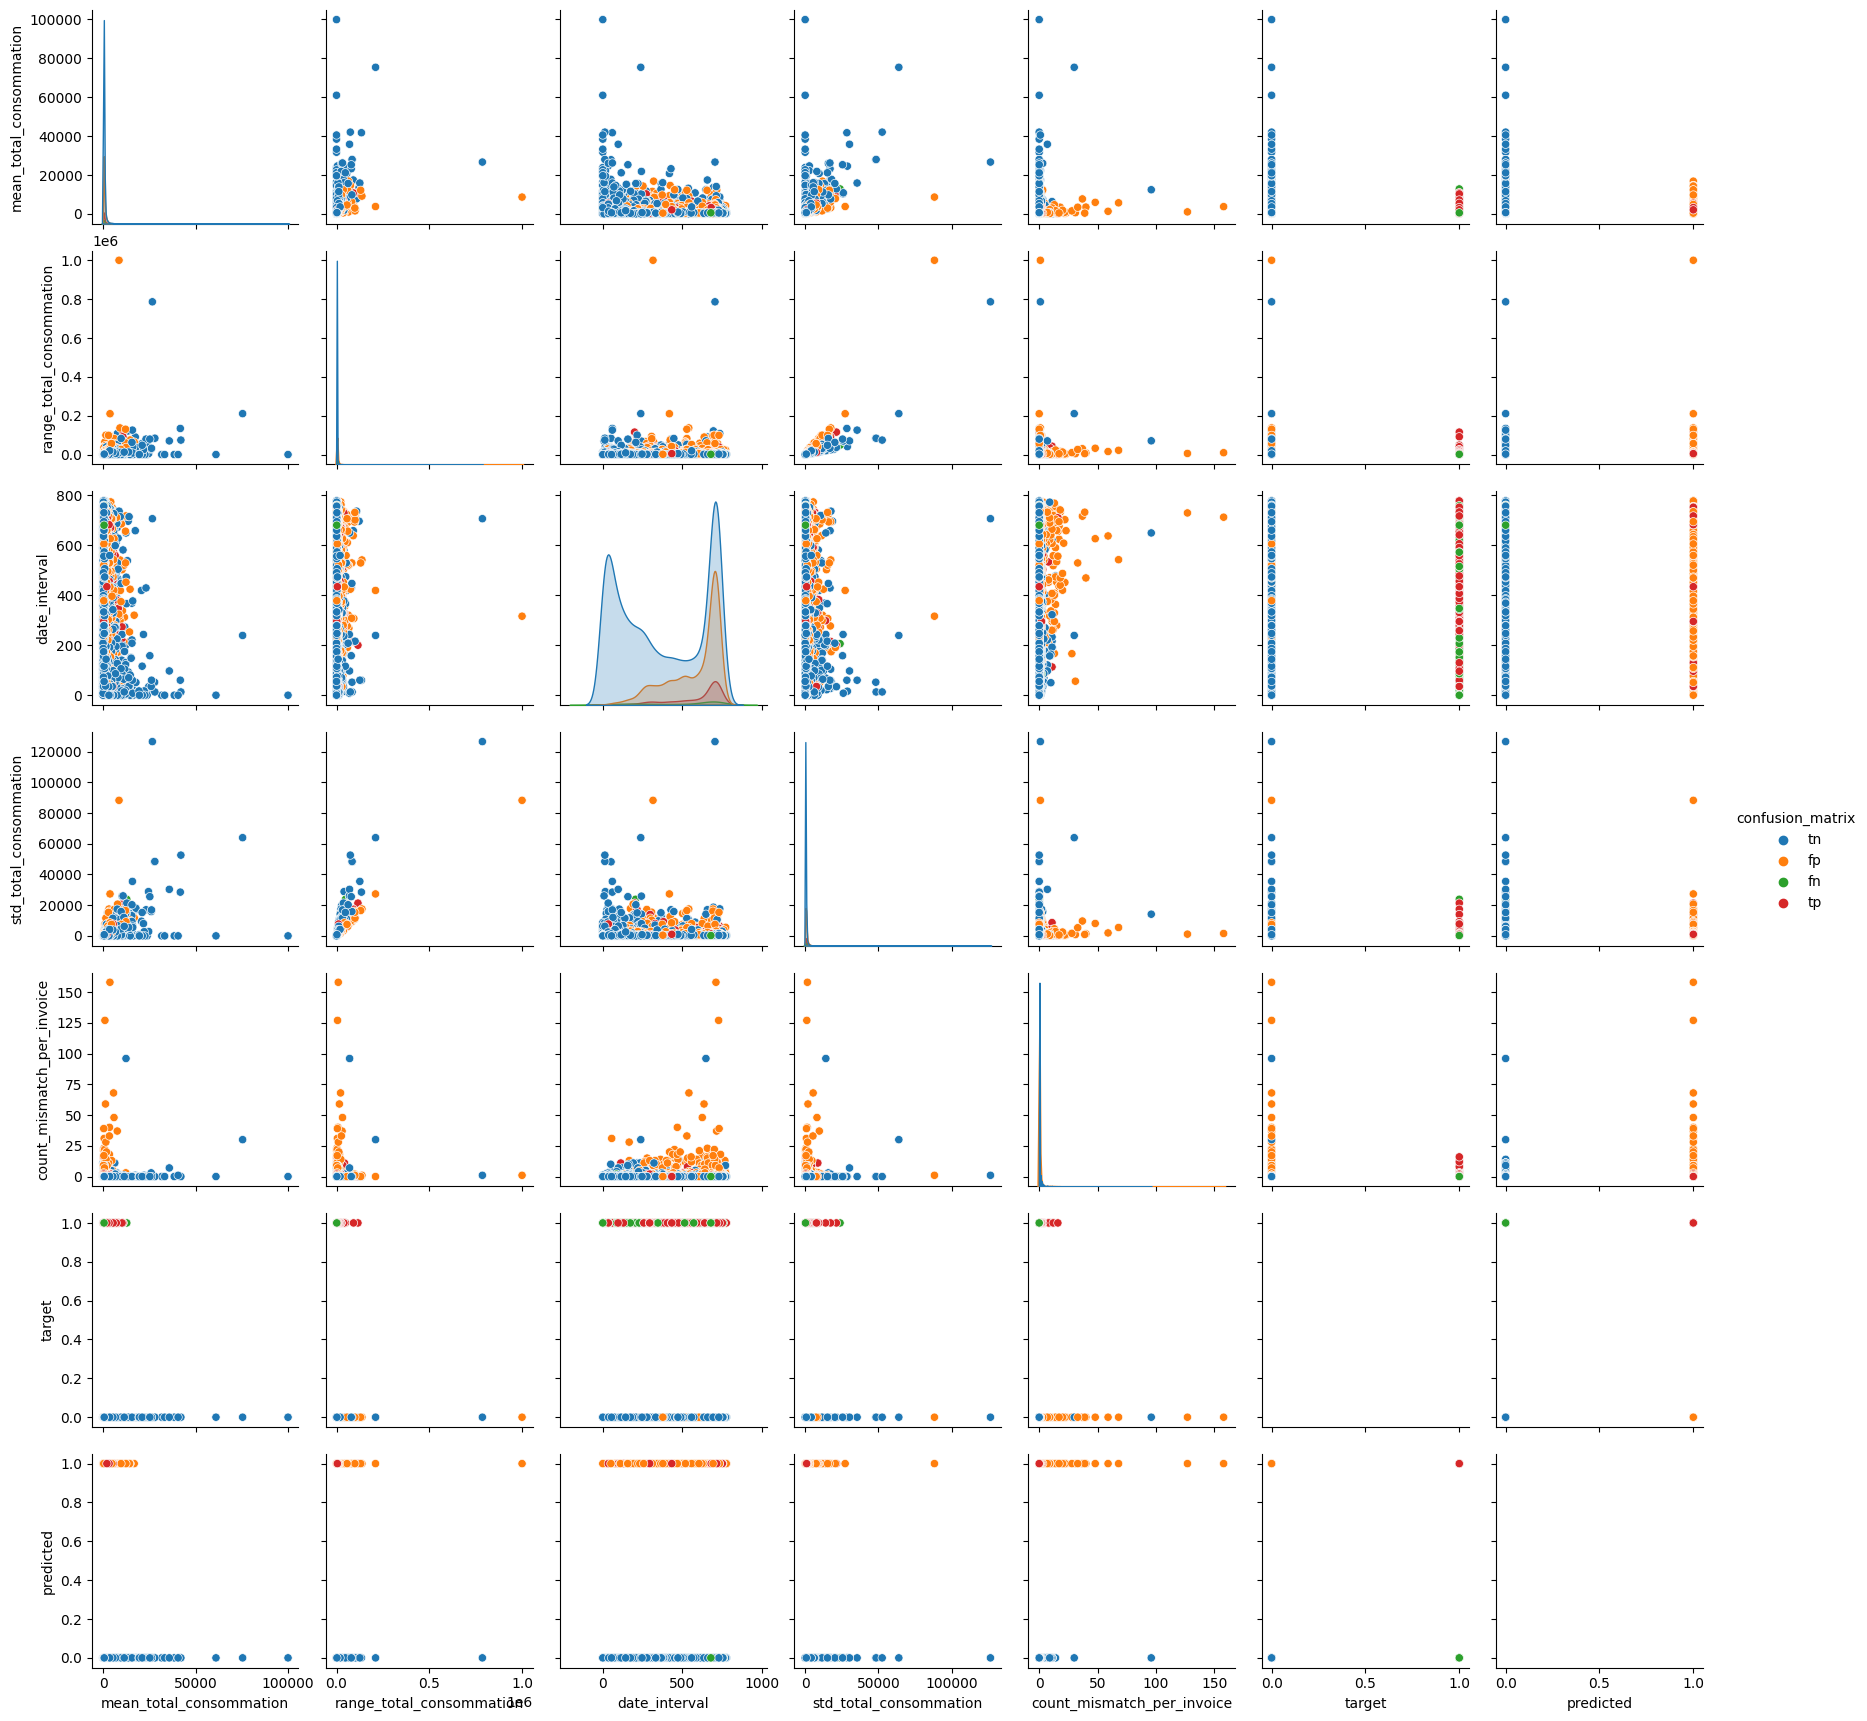

In [66]:
sns.pairplot(x_test_labeled, hue='confusion_matrix')

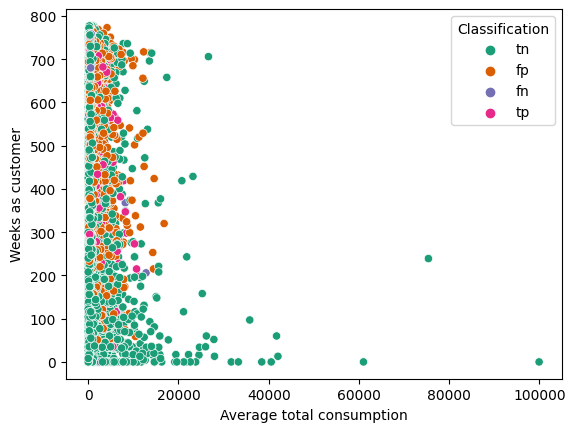

In [67]:
# focus on interesting panel: average total consumption vs weeks as a customer

fig = sns.scatterplot(x_test_labeled, x='mean_total_consommation', y='date_interval', hue='confusion_matrix', palette='Dark2')
fig.set(xlabel='Average total consumption', ylabel='Weeks as customer')
fig.legend(title='Classification')
plt.style.use('dark_background')
plt.show()

# a lot of false positives are clustered around higher numbers in weeks as a customer. The model seems to overrate this feature. 

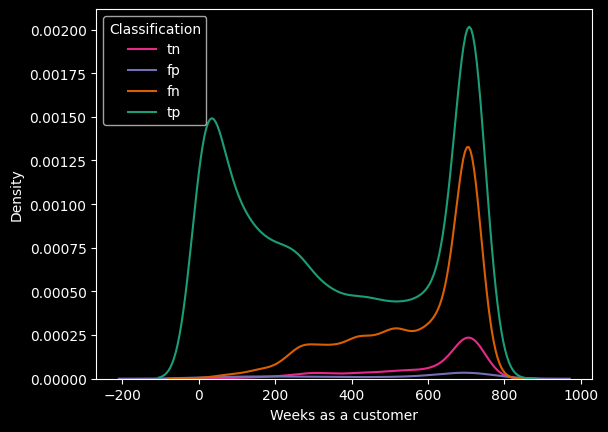

In [68]:
fig = sns.kdeplot(x_test_labeled, x='date_interval', hue='confusion_matrix', palette='Dark2')
fig.set(xlabel='Weeks as a customer', ylabel='Density')
fig.legend(['tn', 'fp', 'fn', 'tp'], title='Classification')
plt.style.use('dark_background')
# plt.figure(figsize=(4, 10))
plt.show()

## Predicting on the competition test data

In [ ]:
## code to predict test data
clients_test = pd.read_csv('data/test/client_test.csv', low_memory=False, parse_dates=True)
invoices_test = pd.read_csv('data/test/invoice_test.csv', low_memory=False, parse_dates=True)

invoices_test['total_consommation'] = invoices_test.eval("consommation_level_1 + consommation_level_2 + consommation_level_3 + consommation_level_4")

invoices_grouped_test = invoices_test.groupby('client_id').mean(numeric_only=True)
invoices_grouped_test.rename(mapper={'total_consommation': 'mean_total_consommation'}, axis=1, inplace=True)
invoices_grouped_test = invoices_grouped_test.reset_index()
agg_clients_test = pd.merge(left=clients_test, right=invoices_grouped_test[['client_id', 'mean_total_consommation']], how='left')

count_num_test = invoices_test.groupby('client_id').counter_number.nunique().to_frame('number_of_counter_numbers').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=count_num_test, on='client_id')
del count_num_test

counter_dict_test = {'A': 0, '0': 0, '1': 1, '5': 5, '4': 4, '3': 3, '2': 2, '769': 0, '618': 0, '269375': 0, '46': 0, '420': 0}
invoices_test.counter_statue = invoices_test.counter_statue.map(lambda x: counter_dict_test.get(x, x)).astype('int')

df_test = pd.merge(left=clients_test, right=invoices_test, on='client_id', how='left')
counter_statues_test = df_test.groupby('client_id').counter_statue.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_counter_statue').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=counter_statues_test, on='client_id')
del counter_statues_test

remarque_dict_test = {5: 6, 207: 6, 413: 6, 203: 6}
invoices_test.reading_remarque = invoices_test.reading_remarque.map(lambda x: remarque_dict_test.get(x, x))

reading_mode_test = invoices_test.groupby('client_id').reading_remarque.apply(stats.mode).apply(lambda x: x[0]).to_frame('mode_reading_remarque').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=reading_mode_test, on='client_id')
del reading_mode_test

min_max_test = invoices_test.groupby('client_id').total_consommation.aggregate(['min', 'max'])
rng_total_consommation_test = min_max_test.apply(lambda x: x.to_list()[1] - x.to_list()[0], axis=1).to_frame('range_total_consommation').reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=rng_total_consommation_test, on='client_id')
del min_max_test

invoices_test['invoice_date'] = pd.to_datetime(invoices_test['invoice_date'])

minmax_date_test = invoices_test.groupby('client_id').invoice_date.aggregate(['min','max']).reset_index()
minmax_date_test['date_interval'] =((minmax_date_test['max'] - minmax_date_test['min']) / np.timedelta64(1, 'W')).astype('int')
agg_clients_test = pd.merge(left=agg_clients_test, right=minmax_date_test[['client_id', 'date_interval']], on='client_id')
del minmax_date_test

gaz_type_test = invoices_test.groupby('client_id').counter_type.aggregate(['max']).reset_index()
gaz_dict_test = {'ELEC': 0, 'GAZ':1}
gaz_type_test['has_gaz'] = gaz_type_test['max'].map(gaz_dict)
agg_clients_test = pd.merge(left=agg_clients_test, right=gaz_type_test.drop('max', axis=1), on='client_id')
del gaz_type_test

std_consommation_test = invoices_test.groupby('client_id').total_consommation.std().reset_index()
std_consommation_test.rename(mapper={'total_consommation': 'std_total_consommation'}, axis=1, inplace=True)
agg_clients_test = pd.merge(left=agg_clients_test, right=std_consommation_test, on='client_id')
del std_consommation_test

invoices_test['diff_index'] = invoices_test['new_index'] - invoices_test['old_index']
invoices_test['count_mismatch_per_invoice'] = invoices_test['total_consommation'] != invoices_test['diff_index']
count_mismatch_test = invoices_test.groupby('client_id')['count_mismatch_per_invoice'].sum().sort_values(ascending=False).reset_index()
agg_clients_test = pd.merge(left=agg_clients_test, right=count_mismatch_test, on='client_id')
del count_mismatch_test

invoices_test['diff_index'] = invoices_test['new_index'] - invoices_test['old_index']
invoices_test['con_ind_mismatch'] = invoices_test['total_consommation'] != invoices_test['diff_index']
count_mismatch_test = invoices_test.groupby('client_id')[['diff_index', 'total_consommation']].sum().sort_values('diff_index', ascending=False).reset_index()
count_mismatch_test['count_mismatch_energy'] = count_mismatch_test['total_consommation'] - count_mismatch_test['diff_index']
count_mismatch_test['count_mismatch_pooled'] = count_mismatch_test['count_mismatch_energy'] != 0 
agg_clients_test = pd.merge(left=agg_clients_test, right=count_mismatch_test[['client_id', 'count_mismatch_pooled']], on='client_id')
del count_mismatch_test

X2 = agg_clients_test.drop(['client_id', 'creation_date'], axis=1)
X2.std_total_consommation = X2.std_total_consommation.fillna(0)

for col in X2.columns:
    if X2[col].nunique() < 30:
        dummie = pd.get_dummies(X2[col], drop_first=True, prefix=col)
        
        X2.drop(columns=col, inplace=True)
        X2 = X2.join(dummie, how='left')


results = pd.concat([agg_clients_test.client_id, pd.Series(gs.predict_proba(X2)[:, 1]).to_frame('target')], axis=1).set_index('client_id')
results.to_csv('results_4.csv')
